In [129]:
import io
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import nltk
import heapq
import numpy as np
from nltk.corpus.reader.conll import ConllCorpusReader, LazyConcatenation, LazyMap

In [22]:
# nltk.download('words')
# nltk.download('maxent_ne_chunker')

In [23]:
###Taken from [https://stackoverflow.com/questions/46872083/ne-tags-in-nltk-conllcorpusreader] [14/11/2022]
class betterConllReader(ConllCorpusReader):

    def iob_words(self, fileids=None, tagset=None, column="ne"):
        """
        :return: a list of word/tag/IOB tuples
        :rtype: list(tuple)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK, self.NE)
        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset, column)
        return LazyConcatenation(LazyMap(get_iob_words, self._grids(fileids)))

    def _get_iob_words(self, grid, tagset=None, column="ne"):
        pos_tags = self._get_column(grid, self._colmap['pos'])
        if tagset and tagset != self._tagset:
            pos_tags = [map_tag(self._tagset, tagset, t) for t in pos_tags]
        return list(zip(self._get_column(grid, self._colmap['words']), pos_tags,
                   self._get_column(grid, self._colmap[column])))

###

In [114]:
def read_data(root_filename, datafiles, column_types):
    # data_stream = pyconll.load_from_file(filename)
    # data = parse(data_stream)

    data = betterConllReader(root_filename, datafiles, columntypes=column_types)
    return data


def extract_annotations(inputfile, annotationcolumn, delimiter='\t'):
    '''
    This function extracts annotations represented in the conll format from a file
    
    :param inputfile: the path to the conll file
    :param annotationcolumn: the name of the column in which the target annotation is provided
    :param delimiter: optional parameter to overwrite the default delimiter (tab)
    :type inputfile: string
    :type annotationcolumn: string
    :type delimiter: string
    :returns: the annotations as a list
    '''
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    conll_input = pd.read_csv(inputfile, sep=delimiter, error_bad_lines=False)
    annotations = conll_input[annotationcolumn].tolist()
    return annotations


def get_class_labels_distribution(data, plot=False, train_data=True):
    labels_counter = defaultdict(int)

    for iob_word in data.iob_words(): 
        labels_counter[iob_word[-1]] += 1

    del labels_counter["O"]
    
    if plot:
        plt.bar(list(labels_counter.keys()), list(labels_counter.values()))
        plt.title("Class label distribution for {}".format("training data" if train_data else "dev data"))
    
    return labels_counter

def get_top_k_words_per_category(data, k=5, category=None):
    words_counter = defaultdict(dict)
    
    for iob_word in data.iob_words():
        word = iob_word[0].lower()
        ne = iob_word[-1]
        if word not in words_counter[ne]:
            words_counter[iob_word[-1]].update({word: 1})
        else:
            words_counter[iob_word[-1]][word] += 1
            
            
    top_k_counter = defaultdict(str)
    if category is None:
        for category_, word_counter in words_counter.items():
            k_keys_sorted = heapq.nlargest(k, word_counter.items(), key=lambda x: x[1])
            top_k_counter[category_] = k_keys_sorted
    else:
        k_keys_sorted = heapq.nlargest(k, words_counter[category].items(), key=lambda x: x[1])
        top_k_counter[category] = k_keys_sorted
            
    return top_k_counter

In [115]:
root_filename = "../../data/"
datafiles = ["conll2003.train.conll", "conll2003.dev.conll"]
column_types = ["words", "pos", "chunk", "ne"]

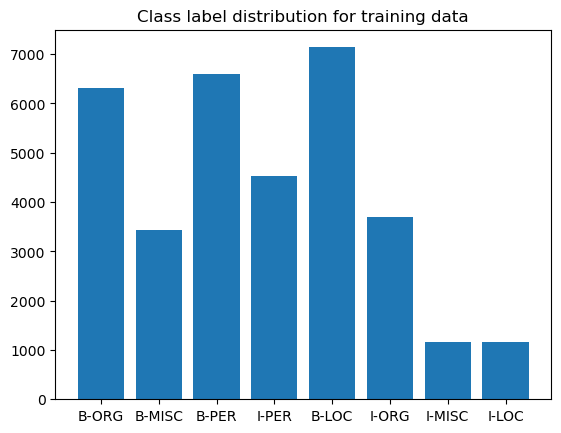

In [116]:
data = read_data(root_filename, [datafiles[0]], column_types)
labels_counter = get_class_labels_distribution(data, plot=True, train_data=True)

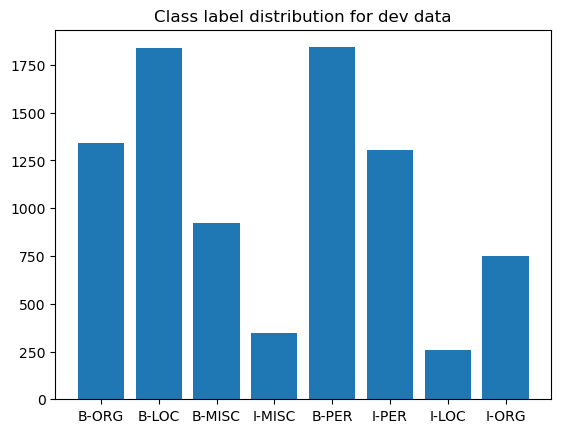

In [117]:
data = read_data(root_filename, [datafiles[1]], column_types)
labels_counter = get_class_labels_distribution(data, plot=True, train_data=False)

In [122]:
top_k_words = get_top_k_words_per_category(data, k=3)
del top_k_words['O']

In [131]:
top_k_words

defaultdict(str,
            {'B-ORG': [('reuters', 23), ('new', 19), ('u.n.', 17)],
             'B-LOC': [('u.s.', 114), ('germany', 48), ('russia', 45)],
             'B-MISC': [('world', 38), ('iraqi', 37), ('european', 27)],
             'I-MISC': [('cup', 47), ('open', 24), ('league', 22)],
             'B-PER': [('wang', 23), ('michael', 18), ('lebed', 18)],
             'I-PER': [('kyi', 12), ('van', 11), ('ahmed', 9)],
             'I-LOC': [('york', 23), ('kong', 14), ('states', 14)],
             'I-ORG': [('of', 23), ('york', 18), ('department', 14)]})

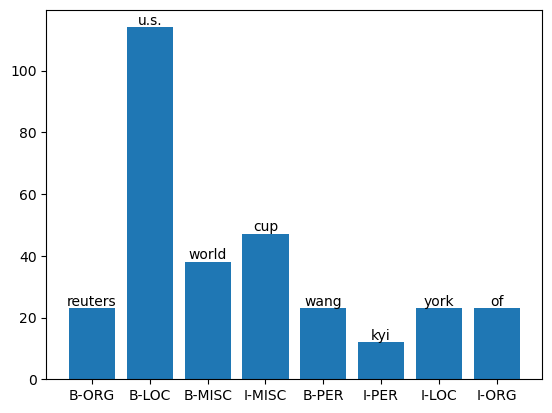

In [143]:
labels = list(top_k_words.keys())

width = 0.35

top_words = []
top_words_count = []

for label in labels:
    word, word_count = top_k_words[label][0]
    top_words.append(word)
    top_words_count.append(word_count)

bar1 = plt.bar(labels, top_words_count)

for i, rect in enumerate(bar1):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, top_words[i], ha='center', va='bottom')

In [133]:
top_k_words

defaultdict(str,
            {'B-ORG': [('reuters', 23), ('new', 19), ('u.n.', 17)],
             'B-LOC': [('u.s.', 114), ('germany', 48), ('russia', 45)],
             'B-MISC': [('world', 38), ('iraqi', 37), ('european', 27)],
             'I-MISC': [('cup', 47), ('open', 24), ('league', 22)],
             'B-PER': [('wang', 23), ('michael', 18), ('lebed', 18)],
             'I-PER': [('kyi', 12), ('van', 11), ('ahmed', 9)],
             'I-LOC': [('york', 23), ('kong', 14), ('states', 14)],
             'I-ORG': [('of', 23), ('york', 18), ('department', 14)]})